In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['errorbar.capsize'] = 6
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b','c','d','e']
enss=['b','c','d']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'cB211.072.64','c':'cC211.060.80','d':'cD211.054.96','e':'cE211.044.112'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96','e':'E112'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692,'e':0.04892} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96,'e':112}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2,'e':112*2}

ens2Z_1d_V={'b':1.1262,'c':1.1573,'d':1.1930,'e':1.2175}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

ens2amu={'a24':0.0053,'a':0.0009,'b':0.00072}
ens2amus={'b':0.0186}
ens2amuc={'b':0.249}
ens2ZP={'a24':(0.4670,0.0046),'a':(0.500,0.030)}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

ens2tfs={'b':range(2,22+1),'c':range(2,26+1),'d':range(2,30+1),'e':range(2,32+1)}

def fsolve2(func,x0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res=fsolve(func, x0)[0]
    return res if res!=x0 else np.NaN

# ens='b'
# ens2a[ens]*hbarc*1000

def find_t_cloest(ens,t):
    return round(t/ens2a[ens])

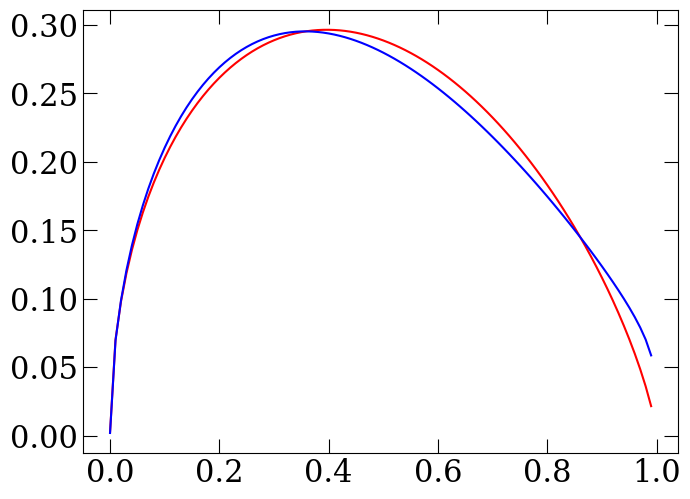

In [23]:
import scipy
xs=np.arange(1e-5,1.02,0.01)

def f(x,a,b,g):
    n=1/(scipy.special.beta(a+1,b+1)+g*scipy.special.beta(a+2,b+1))
    return n*(x**a * (1-x)**b * (1+g*x))*x

a,b,r=-0.507,0.75,0
ys=[f(x,a,b,r) for x in xs]
plt.plot(xs,ys,'r-')

a,b,r=-0.476,0.21,-0.810
# r=-0.81
ys=[f(x,a,b,r) for x in xs]
plt.plot(xs,ys,'b-')

# None

# a,b,r=0.41,1.99,0
# ys=[f(x,a,b,r) for x in xs]
# plt.plot(xs,ys,'r-')

# a,b,r=0.46,1.47,-0.765
# # r=-0.765
# ys=[f(x,a,b,r) for x in xs]
# plt.plot(xs,ys,'b-')

None

In [4]:
ens2RCs={ens:{} for ens in enss}

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/paperRenorms.txt'
with open(path,'r') as f:
    rcs=f.read().splitlines()

Zs=['Zqq(mu=nu)','Zqq(mu!=nu)','Zqq^s(mu=nu)','Zqq^s(mu!=nu)','Zqg(mu!=nu)','Zgq(mu=nu)','Zgq(mu!=nu)']
for iZ,Z in enumerate(Zs):
    for iens,ens in enumerate(enss):
        t=rcs[iZ*4+iens]
        if '(' not in t:
            ens2RCs[ens][Z] = float(t)
            ens2RCs[ens][Z+'_err'] = 0
        else:
            ind_dot=t.find('.')
            ind_b=t.find('(')
            ind_k=t.find(')')
            ens2RCs[ens][Z] = float(t[:ind_b])
            ens2RCs[ens][Z+'_err'] = float(t[ind_b+1:ind_k]) * 10**(-(ind_b-ind_dot)+1)

for ens,ensL in zip(['b','c','d'],['cB64','cC80','cD96']):
    path=f'/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/Zgg_c{ens.upper()}4.txt'
    with open(path,'r') as f:
        t=f.read().splitlines()
        for i,row in enumerate(t):
            # if i==0:
            #     continue
            nstout,mean,err=[float(ele) for ele in row.split('\t')]
            nstout=int(nstout)
            assert(nstout==i)
            ens2RCs[ens][f'Zgg^{i}(mu!=nu)']=mean
            ens2RCs[ens][f'Zgg^{i}(mu!=nu)_err']=err
            
path='data_aux/RCs.pkl'
with open(path,'wb') as f:
    pickle.dump(ens2RCs,f)

In [5]:
ens2RCs={}
path='data_aux/RCs.pkl'
with open(path,'rb') as f:
    ens2RCs=pickle.load(f)

precisions=[1,1,2,1,0,3,3]
for iZ,Z in enumerate(Zs):
    print(Z,[yu.un2str(ens2RCs[ens][Z],ens2RCs[ens][Z+'_err'],precisions[iZ]) if ens2RCs[ens][Z+'_err']!=0 else ens2RCs[ens][Z] for ens in enss])
for stout in range(5,10+1):
    Z=f'Zgg^{stout}(mu!=nu)'
    print(Z,[yu.un2str(ens2RCs[ens][Z],ens2RCs[ens][Z+'_err'],1 if ens=='b' else 2) for ens in enss])

Zqq(mu=nu) ['1.1167(4)', '1.1460(2)', '1.1807(2)']
Zqq(mu!=nu) ['1.1262(4)', '1.1573(3)', '1.1930(2)']
Zqq^s(mu=nu) ['1.075(13)', '1.124(23)', '1.178(15)']
Zqq^s(mu!=nu) ['1.134(8)', '1.155(8)', '1.205(5)']
Zqg(mu!=nu) [-0.0424, -0.058, -0.0752]
Zgq(mu=nu) ['0.0658(206)', '0.0410(199)', '0.0139(192)']
Zgq(mu!=nu) ['0.0772(171)', '0.0521(166)', '0.0246(160)']
Zgg^5(mu!=nu) ['0.723(9)', '0.724(27)', '0.776(44)']
Zgg^6(mu!=nu) ['0.743(9)', '0.756(26)', '0.799(41)']
Zgg^7(mu!=nu) ['0.764(9)', '0.784(25)', '0.821(39)']
Zgg^8(mu!=nu) ['0.782(8)', '0.807(25)', '0.839(37)']
Zgg^9(mu!=nu) ['0.798(8)', '0.826(24)', '0.855(36)']
Zgg^10(mu!=nu) ['0.811(8)', '0.841(23)', '0.867(34)']


In [11]:
import pickle

ens2RCs={}
path='data_aux/RCs.pkl'
with open(path,'rb') as f:
    ens2RCs=pickle.load(f)
    
print(ens2RCs.keys())
print(ens2RCs['b'].keys())
print(ens2RCs['b']['Zqq(mu=nu)'],ens2RCs['b']['Zqq(mu=nu)_err'])

dict_keys(['b', 'c', 'd'])
dict_keys(['Zqq(mu=nu)', 'Zqq(mu=nu)_err', 'Zqq(mu!=nu)', 'Zqq(mu!=nu)_err', 'Zqq^s(mu=nu)', 'Zqq^s(mu=nu)_err', 'Zqq^s(mu!=nu)', 'Zqq^s(mu!=nu)_err', 'Zqg(mu!=nu)', 'Zqg(mu!=nu)_err', 'Zgq(mu=nu)', 'Zgq(mu=nu)_err', 'Zgq(mu!=nu)', 'Zgq(mu!=nu)_err', 'Zgg^0(mu!=nu)', 'Zgg^0(mu!=nu)_err', 'Zgg^1(mu!=nu)', 'Zgg^1(mu!=nu)_err', 'Zgg^2(mu!=nu)', 'Zgg^2(mu!=nu)_err', 'Zgg^3(mu!=nu)', 'Zgg^3(mu!=nu)_err', 'Zgg^4(mu!=nu)', 'Zgg^4(mu!=nu)_err', 'Zgg^5(mu!=nu)', 'Zgg^5(mu!=nu)_err', 'Zgg^6(mu!=nu)', 'Zgg^6(mu!=nu)_err', 'Zgg^7(mu!=nu)', 'Zgg^7(mu!=nu)_err', 'Zgg^8(mu!=nu)', 'Zgg^8(mu!=nu)_err', 'Zgg^9(mu!=nu)', 'Zgg^9(mu!=nu)_err', 'Zgg^10(mu!=nu)', 'Zgg^10(mu!=nu)_err', 'Zgg^11(mu!=nu)', 'Zgg^11(mu!=nu)_err', 'Zgg^12(mu!=nu)', 'Zgg^12(mu!=nu)_err', 'Zgg^13(mu!=nu)', 'Zgg^13(mu!=nu)_err', 'Zgg^14(mu!=nu)', 'Zgg^14(mu!=nu)_err', 'Zgg^15(mu!=nu)', 'Zgg^15(mu!=nu)_err', 'Zgg^16(mu!=nu)', 'Zgg^16(mu!=nu)_err', 'Zgg^17(mu!=nu)', 'Zgg^17(mu!=nu)_err', 'Zgg^18(mu!=nu)', 'Zgg

In [3]:
cfg2old=lambda cfg: cfg[1:]+'_r'+{'a':'0','b':'1','c':'2','d':'3'}[cfg[0]]
cfg2new=lambda cfg: {'0':'a','1':'b','2':'c','3':'d'}[cfg[-1]] + cfg[:4]

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/cfgs_conn/B_confs'
with open(path,'r') as f:
    cfgs=f.read().splitlines()
    cfgs_conn=[cfg2new(cfg) for cfg in cfgs]
    
path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/dataPrepare/cB211.072.64/data_aux/cfgs_N=200,85,64_jlscg'
with open(path,'r') as f:
    cfgs_disc=f.read().splitlines()

cfgs=list(set(cfgs_conn).intersection(cfgs_disc))
cfgs.sort()

print(len(cfgs_conn),len(cfgs_disc),len(cfgs))

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/cfgs_run_B'
with open(path,'w') as f:
    f.write('\n'.join(cfgs))

731 743 725


In [4]:
cfg2old=lambda cfg: cfg[1:]+'_r'+{'a':'0','b':'1','c':'2','d':'3'}[cfg[0]]
cfg2new=lambda cfg: {'0':'a','1':'b','2':'c','3':'d'}[cfg[-1]] + cfg[:4]

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/cfgs_conn/configs_cC80_Christian.txt'
with open(path,'r') as f:
    cfgs=f.read().split("'")
    cfgs=[cfg for cfg in cfgs if len(cfg)==7 and '_r' in cfg]
    cfgs_conn=[cfg2new(cfg) for cfg in cfgs]
    
path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/dataPrepare/cC211.060.80/data_aux/cfgs_N=650_jlscg'
with open(path,'r') as f:
    cfgs_disc=f.read().splitlines()

cfgs=list(set(cfgs_conn).intersection(cfgs_disc))
cfgs.sort()

print(len(cfgs_conn),len(cfgs_disc),len(cfgs))

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/cfgs_run_C'
with open(path,'w') as f:
    f.write('\n'.join(cfgs))

401 400 400


In [2]:
cfg2old=lambda cfg: cfg[1:]+'_r'+{'a':'0','b':'1','c':'2','d':'3'}[cfg[0]]
cfg2new=lambda cfg: {'0':'a','1':'b','2':'c','3':'d'}[cfg[-1]] + cfg[:4]

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/cfgs_conn/configs_cD96_Christian.txt'
with open(path,'r') as f:
    cfgs=f.read().split("'")
    cfgs=[cfg for cfg in cfgs if len(cfg)==7 and '_r' in cfg]
    cfgs_conn=[cfg2new(cfg) for cfg in cfgs]
    
path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/dataPrepare/cD211.054.96/data_aux/cfgs_N=256,112_jlscg'
with open(path,'r') as f:
    cfgs_disc=f.read().splitlines()

cfgs=list(set(cfgs_conn).intersection(cfgs_disc))
cfgs.sort()

print(len(cfgs_conn),len(cfgs_disc),len(cfgs))

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/cfgs_run_D'
with open(path,'w') as f:
    f.write('\n'.join(cfgs))

496 493 493
